## Diagnostic Analysis of NHS appointment data using Python

To begin let's review the information provided that we will be using to conduct our analysis:

**Data available:**
- _actual duration.csv_
  - details of appointments made by patients. The data contains:
    - ICB location, codes for location & region ons, appointment date, duration and # of appointments
- _appointments_regional.csv_
  - Details on the type of appointments made by patients. The data contains:
    - ICB code, appointment month, appointment status (Attended/ DNA), healthcare professional (hcp) type, appointment type (phone/ facetoface etc), time between booking and appointment, count of appointments
- _national_categories.csv_
  - Details of the national categories of appointments made by patients. The data contains:
    - appointment date, ICB code, location name, service setting, national category
- _tweets.csv_
  - Data related to healthcare in the UK scraped from Twitter. The data contains:
    - tweet id, tweet contect, tweet entitities, hashtags, metadata, retweet count, favourite cout, favourited?, retweeted? language
    
**Additional data:**
-   _pop_data_2021_2_ons_
       - As well as the provided data I am also importing information on population data by ICB from the Office for National Statistics [Health geographies population estimates](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/clinicalcommissioninggroupmidyearpopulationestimates) 
       - I have taken the Mid-2021 and mid-2022 edition of this dataset and will be using this as a rough guide on the population over this period. Small edits were made to the original data set to align column titles and remove unneccesary columns, the dataset contains: 
         - sub_icb_location_ons_code, sub_icb_location_name, icb_ons_code and Total Population
- _NHS_Workforce_Statistics_July_22_England_and_Organisation_20_22.csv_
  - This dataset contains staffing data for the NHS across the time period 2020 - 2022 and was taken from the NHS website [NHS Workforce Statistics](https://digital.nhs.uk/data-and-information/publications/statistical/nhs-workforce-statistics/july-2022)
  - Relevant data for FTE workers (as opposed to just the headcount) has been extracted from the 'NHS Workforce Statistics, July 2022 England and Organisation' xlsx file. The dataset contains:
    - Date, London, South West, South East, Midlands, East of England, North West, North East and Yorkshire
    - Date is a month data type and each following column contains total number of staff (FTE) for that month as an integer
  
       
**Two main questions for our analysis:**
- Has there been adequate staff and capacity in the networks?
- What was the actual utilisation of resources?

**Questions to investigate at this initial stage**
1. What is the number of locations, service settings, context types, national categories, and appointment statuses in the data sets?
2. What is the date range of the provided data sets, and which service settings reported the most appointments for a specific period?
3. What is the number of appointments and records per month?
4. What monthly and seasonal trends are evident, based on the number of appointments for service settings, context types, and national categories?
5. What are the top trending hashtags (#) on the supplied Twitter data set and how can this be used in the decision-making process?
6. Was there adequate staff and capacity in the networks?
7. What was the actual utilisation of resources?
8. What insights can be gained by looking at missed appointments?

In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
#allow for bold text in print functions:
bold = '\033[1m'
reset = '\033[0m'

### Importing the data and sense-checking

In [2]:
# Importing and sense-checking the actual_duration.csv into a DataFrame (table)
ad = pd.read_csv('actual_duration.csv')
# View the DataFrame.
ad.head()

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,6-10 Minutes,1698
3,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,Unknown / Data Quality,1277
4,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,16-20 Minutes,730


In [3]:
#small initial exploration of the data to ensure correct importing
ad.info()
ad.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB


,count_of_appointments
count,137793.000000
mean,1219.080011
std,1546.902956
min,1.000000
25%,194.000000
50%,696.000000
75%,1621.000000
max,15400.000000


In [4]:
#we can see from the above dtypes that appointment_date is an object type so we convert it to a datetime object below
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'], format='%d-%b-%y')

In [5]:
ad.dtypes

sub_icb_location_code                object
sub_icb_location_ons_code            object
sub_icb_location_name                object
icb_ons_code                         object
region_ons_code                      object
appointment_date             datetime64[ns]
actual_duration                      object
count_of_appointments                 int64
dtype: object

In [6]:
#importing appointments_regional.csv into a DataFrame (table)
ar = pd.read_csv('appointments_regional.csv')
#view DataFrame
ar.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


In [7]:
ar.info()
ar.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB


,count_of_appointments
count,596821.000000
mean,1244.601857
std,5856.887042
min,1.000000
25%,7.000000
50%,47.000000
75%,308.000000
max,211265.000000


In [8]:
#as before appointment_month is an object so we convert it to a datetime object
#as there is no day specified in appointment month we use the period function to cast the object as a period [month] object
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'], format='%Y-%m')
ar['appointment_month'] = ar['appointment_month'].dt.to_period('M')

ar.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


In [9]:
#import national_categories.csv into a DataFrame (table)
nc = pd.read_csv('national_categories.csv')
#view DataFrame
nc.head()

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,02/08/2021,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08
1,02/08/2021,E54000050,NHS North East and North Cumbria ICB - 00L,Other,Care Related Encounter,Planned Clinics,7,2021-08
2,02/08/2021,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Home Visit,79,2021-08
3,02/08/2021,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,General Consultation Acute,725,2021-08
4,02/08/2021,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Structured Medication Review,2,2021-08


In [10]:
#sense check the data and data types
nc.info()
nc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   appointment_date       817394 non-null  object
 1   icb_ons_code           817394 non-null  object
 2   sub_icb_location_name  817394 non-null  object
 3   service_setting        817394 non-null  object
 4   context_type           817394 non-null  object
 5   national_category      817394 non-null  object
 6   count_of_appointments  817394 non-null  int64 
 7   appointment_month      817394 non-null  object
dtypes: int64(1), object(7)
memory usage: 49.9+ MB


,count_of_appointments
count,817394.000000
mean,362.183684
std,1084.576600
min,1.000000
25%,7.000000
50%,25.000000
75%,128.000000
max,16590.000000


In [11]:
#convert appointment date and appointment month to a datetime object
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'], format='%d/%m/%Y')

nc['appointment_month'] = pd.to_datetime(nc['appointment_month'], format='%Y-%m')
nc['appointment_month'] = nc['appointment_month'].dt.to_period('M')

nc.dtypes

appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appointments             int64
appointment_month             period[M]
dtype: object

In [12]:
#import twitter (X) data
tweets = pd.read_csv('tweets.csv')

# View the DataFrame.
tweets.head()

,tweet_id,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_metadata,tweet_retweet_count,tweet_favorite_count,tweet_favorited,tweet_retweeted,tweet_lang
0,1567629223795527681,As Arkansas’ first Comprehensive Stroke Certif...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en
1,1567582846612553728,RT @AndreaGrammer: Work-life balance is at the...,"{'hashtags': [{'text': 'PremiseHealth', 'indic...","#PremiseHealth, #hiring","{'iso_language_code': 'en', 'result_type': 're...",2,0,False,False,en
2,1567582787070304256,RT @OntarioGreens: $10 billion can go a long w...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",39,0,False,False,en
3,1567582767625428992,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...,"{'hashtags': [{'text': 'NEW', 'indices': [20, ...",#NEW,"{'iso_language_code': 'en', 'result_type': 're...",5,0,False,False,en
4,1567582720460570625,ICYMI: Our recent blogs on Cybersecurity in Ac...,"{'hashtags': [{'text': 'blogs', 'indices': [18...","#blogs, #digitaltransformation, #cybersecurity...","{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en


In [13]:
#import population data from Off for National Statistics (ONS)
pop_data = pd.read_csv('../LSE_DA201_Assignment_files/submission/pop_data_2021_2_ons.csv')

pop_data.head()

,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,Total
0,E38000006,NHS South Yorkshire ICB - 02P,E54000061,"244,887"
1,E38000007,NHS Mid and South Essex ICB - 99E,E54000026,"264,829"
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,E54000060,"118,327"
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,E54000048,"154,954"
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,E54000048,"140,976"


In [14]:
pop_data.info()
pop_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sub_icb_location_ons_code  106 non-null    object
 1   sub_icb_location_name      106 non-null    object
 2   icb_ons_code               106 non-null    object
 3   Total                      106 non-null    object
dtypes: object(4)
memory usage: 3.4+ KB


,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,Total
count,106,106,106,106
unique,106,106,42,106
top,E38000006,NHS South Yorkshire ICB - 02P,E54000057,"244,887"
freq,1,1,10,1


In [15]:
#convert Total in pop_data to an integer and rename as Total Population
pop_data['Total'] = pop_data['Total'].replace({',': ''}, regex=True).astype(int)
pop_data = pop_data.rename(columns={'Total': 'total_population'})

In [16]:
#import population data from Off for National Statistics (ONS)
staff_data = pd.read_csv('../LSE_DA201_Assignment_files/submission/NHS_Workforce_Statistics_July_22_England_and_Organisation_20_22.csv')

staff_data.head()

,Date,London,South West,South East,Midlands,East of England,North West,North East and Yorkshire
0,Jan-20,"193,959","107,890","151,794","209,145","105,918","172,965","186,854"
1,Feb-20,"194,470","108,424","152,276","209,995","106,367","173,363","187,497"
2,Mar-20,"195,510","109,274","153,246","211,279","107,099","174,543","188,469"
3,Apr-20,"197,343","110,085","154,383","213,195","107,555","176,680","190,813"
4,May-20,"198,913","110,666","155,274","214,195","108,048","178,424","192,219"


In [17]:
staff_data.info()
staff_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      31 non-null     object
 1   London                    31 non-null     object
 2   South West                31 non-null     object
 3   South East                31 non-null     object
 4   Midlands                  31 non-null     object
 5   East of England           31 non-null     object
 6   North West                31 non-null     object
 7   North East and Yorkshire  31 non-null     object
dtypes: object(8)
memory usage: 2.1+ KB


,Date,London,South West,South East,Midlands,East of England,North West,North East and Yorkshire
count,31,31,31,31,31,31,31,31
unique,31,31,31,31,31,31,31,31
top,Jan-20,"193,959","107,890","151,794","209,145","105,918","172,965","186,854"
freq,1,1,1,1,1,1,1,1


In [18]:
#remove commas so datapoints are recognised as integers and  cast all staff numbers as integers
staff_data[['London', 'South West','South East','Midlands',\
            'East of England','North West','North East and Yorkshire']] = \
staff_data[['London', 'South West','South East','Midlands',\
            'East of England','North West','North East and Yorkshire']].replace({',': ''}, regex=True).astype(int)

In [19]:
#cast date as a datime object
staff_data['Date'] = pd.to_datetime(staff_data['Date'], format='%b-%y')
staff_data.dtypes

Date                        datetime64[ns]
London                               int32
South West                           int32
South East                           int32
Midlands                             int32
East of England                      int32
North West                           int32
North East and Yorkshire             int32
dtype: object

We can see from the above that the data has been imported correctly and has no null values.

A small amount of cleaning was done to correct data types and clarify column names and so with our cleaned data we can now continue to explore further.

### Exploring the data set

Let's begin by exploring the total appointment counts for each sub icb location compared to their population. 

This will allow us to see if the icbs are comparable and will mean that going forward we can select a subset of icbs for further analysis.

We will also explore here the specific icb locations with the highest number of appointments.

In [20]:
#to prepare for comparison we must group each set of data by their sub_icb_location 
#and then sum the relevant data (population and appointment count)

#group population data by location and find total population for each location
pop_data_sums = pop_data.groupby('sub_icb_location_name', as_index=False)['total_population'].sum().\
                sort_values(by='total_population', ascending=False)

#group national categories data by location and find total appointment count for each location
nc_sums = nc.groupby('sub_icb_location_name', as_index=False)['count_of_appointments'].sum()\
          .sort_values(by='count_of_appointments', ascending=False)

#group actual duration data by location and find total appointment count for each location
ad_sums = ad.groupby('sub_icb_location_name', as_index=False)['count_of_appointments'].sum()\
          .sort_values(by='count_of_appointments', ascending=False)

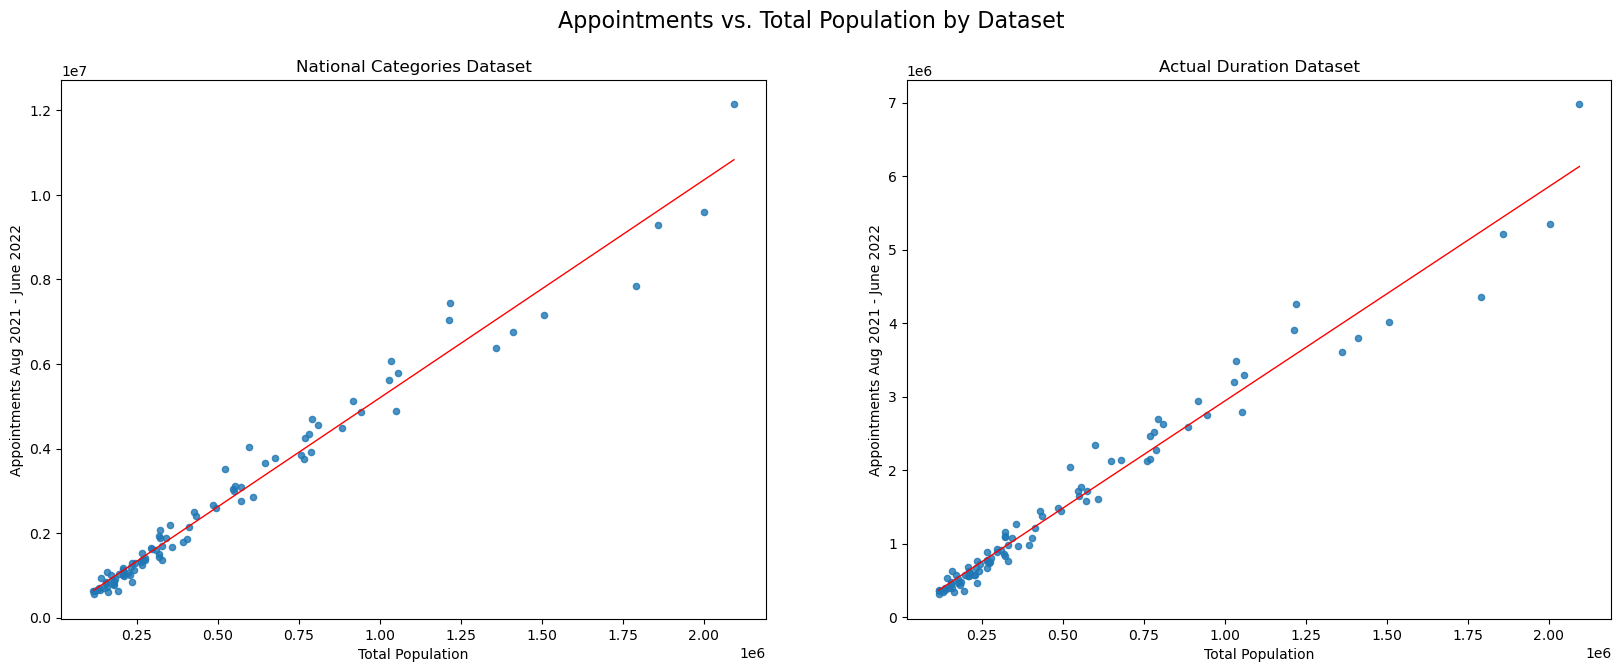

In [21]:
#To create a visualisation we need to merge the daat we would like to visualise:
#create two new Dataframes, merging population data with nc and then with ad
merged_nc_data = pop_data.merge(nc_sums, on='sub_icb_location_name', how='left')
merged_ad_data = pop_data.merge(ad_sums, on='sub_icb_location_name', how='left')

#create a scatteplot to view if there is a trend in the data sets
fig, axes = plt.subplots(1,2,figsize=(20, 7))
sns.regplot(data=merged_nc_data, x='total_population', y='count_of_appointments', ax=axes[0], 
            scatter_kws={"s": 20}, line_kws={"lw":1, "color": "red"}, ci=None)
axes[0].set_title('National Categories Dataset')  # Add a title
axes[0].set_xlabel('Total Population')
axes[0].set_ylabel('Appointments Aug 2021 - June 2022')
sns.regplot(data=merged_ad_data, x='total_population', y='count_of_appointments', ax=axes[1],
            scatter_kws={"s": 20}, line_kws={"lw":1, "color": "red"}, ci=None)
axes[1].set_title('Actual Duration Dataset')  # Add a title
axes[1].set_xlabel('Total Population')
axes[1].set_ylabel('Appointments Aug 2021 - June 2022')
fig.suptitle('Appointments vs. Total Population by Dataset', fontsize=16)
#NB: ci will be deprecated soon and be updated to 'errorbar'
plt.savefig('Population_Appointments 21_22.png')

**NB: the y axis of these graphs are of very different proportions**

This data shows a strong positive correlation between population and appointment count in both national categories and actual duration data sets. This shows that the higher the population in an area the more appointments they will have booked.

This is a good start as if we had a plateau at the higher end we would immediately know that the capacity for those larger populations was not sufficient. However as that is not the case, we have clarified information about the data and can continue along another vein for further exploration.

_______________________________________________________________________________________________________________
We begin our further exploration by looking at our original set of questions.

The first question we look to answer is:

**1.**  What is the number of locations, service settings, context types, national categories, and appointment statuses in the data sets?

Let's break this down into smaller chunks:

_(Note than each section from 1b. onwards lists the data as a percentage for easier comparison, if counts would be preferred there is commented code that can be un-commented to do this.)_

**1a: How many locations are there in the data set?**

In [22]:
# Determine the number of locations.
unique_location =  nc['sub_icb_location_name'].nunique()

print("Count of locations: ", unique_location)

Count of locations:  106


**1b: How many service settings are there in the data set?**

In [23]:
#create a user defined function that calculates the number of unique values in a specific column 
#and their percentages by appointment count
def column_count_by_sum(df, column_name):
    """
    Parameters:
    df : The DataFrame to analyse.
    column_name (str): The column name to analyse.
    """ 
    #Define the count column (column to sum) as appointment counts
    count_column='count_of_appointments'
    
    # Determine the number of unique values in the column
    unique_values = df[column_name].nunique()
    print(f"{bold}Count of unique values in '{column_name}':{reset}", unique_values)
    
    print("_" * 80)  #line for readability
    
    # Group by the specified column and sum the count_column
    value_counts = df.groupby(column_name)[count_column].sum()
    
    # Calculate the percentages based on the sum
    percentage_counts = (value_counts / value_counts.sum()) * 100
    
    # Formatting to include percentage sign to 2 decimal places
    formatted_percentages = percentage_counts.apply(lambda x: f"{x:.2f}%")
    
    #print results
    print(f"{bold}List of {column_name} by percentage of '{count_column}':{reset}")
    print(formatted_percentages)

In [24]:
# Determine the number of service settings.
column_count_by_sum(nc, 'service_setting')

#code to list count of service settings:
#ss_value_counts = nc.groupby('service_setting')['count_of_appointments'].sum()
#print('List of Services: ', ss_value_counts)

Count of unique values in 'service_setting': 5
________________________________________________________________________________
List of service_setting by percentage of 'count_of_appointments':
service_setting
Extended Access Provision     0.74%
General Practice             91.48%
Other                         1.83%
Primary Care Network          2.21%
Unmapped                      3.74%
Name: count_of_appointments, dtype: object


**1c: How many context types are there in the data set?**

In [25]:
# Determine the number of service settings.
column_count_by_sum(nc, 'context_type')

#code to list numerical count of context types:
#ct_value_counts = nc.groupby('context_type')['count_of_appointments'].sum()
#print('List of Context Types: ', ct_value_counts)

Count of unique values in 'context_type': 3
________________________________________________________________________________
List of context_type by percentage of 'count_of_appointments':
context_type
Care Related Encounter    86.84%
Inconsistent Mapping       9.42%
Unmapped                   3.74%
Name: count_of_appointments, dtype: object


**1d: How many national categories are there in the data set?**

In [26]:
# Determine the number of national categories
column_count_by_sum(nc, 'national_category')

#code to list numerical count of national categories
#nc_value_counts = nc.groupby('national_category')['count_of_appointments'].sum()
#print('List of National Categories: ', nc_value_counts)

Count of unique values in 'national_category': 18
________________________________________________________________________________
List of national_category by percentage of 'count_of_appointments':
national_category
Care Home Needs Assessment & Personalised Care and Support Planning     0.14%
Care Home Visit                                                         0.21%
Clinical Triage                                                        14.03%
General Consultation Acute                                             18.14%
General Consultation Routine                                           32.86%
Group Consultation and Group Education                                  0.02%
Home Visit                                                              0.72%
Inconsistent Mapping                                                    9.42%
Non-contractual chargeable work                                         0.05%
Patient contact during Care Home Round                                  0.27%
Pla

**1e: How many appointment statuses are there in the data set?**

In [27]:
# Determine the number of appointment statuses.
column_count_by_sum(ar, 'appointment_status')

#code to list numerical count of appointment statuses
#as_value_counts =ar.groupby('appointment_status')['count_of_appointments'].sum()
#print('List of Appointment Statuses: ', as_value_counts)

Count of unique values in 'appointment_status': 3
________________________________________________________________________________
List of appointment_status by percentage of 'count_of_appointments':
appointment_status
Attended    91.24%
DNA          4.16%
Unknown      4.60%
Name: count_of_appointments, dtype: object


_________________________________________________________

**Question 2: What is the date range of the provided data sets, and which service settings reported the most appointments for a specific period?**

**Question 2a:** What is the date range of the provided data sets

In [28]:
#double check the datatypes of the datasets
print(f'{bold}Data types for appointment date/ month columns:{reset}')
print('national categories:    ', nc['appointment_date'].dtypes)
print('actual duration:        ', ad['appointment_date'].dtypes)
print('appointments regional:  ', ar['appointment_month'].dtypes)

Data types for appointment date/ month columns:
national categories:     datetime64[ns]
actual duration:         datetime64[ns]
appointments regional:   period[M]


In [29]:
#the minimum and maximum dates in the ad DataFrame.
print('The first appointment date in the national categories data set is',ad['appointment_date'].min())
print('The last appointment date in the national categories data set is',ad['appointment_date'].max())

The first appointment date in the national categories data set is 2021-12-01 00:00:00
The last appointment date in the national categories data set is 2022-06-30 00:00:00


In [30]:
#the minimum and maximum dates in the nc DataFrame.
print('The first appointment date in the national categories data set is',nc['appointment_date'].min())
print('The last appointment date in the national categories  data set is',nc['appointment_date'].max())

The first appointment date in the national categories data set is 2021-08-01 00:00:00
The last appointment date in the national categories  data set is 2022-06-30 00:00:00


In [31]:
#the minimum and maximum dates in the ar DataFrame.
print('The first appointment date in the national categories data set is',ar['appointment_month'].min())
print('The last appointment date in the national categories  data set is',ar['appointment_month'].max())

The first appointment date in the national categories data set is 2020-01
The last appointment date in the national categories  data set is 2022-06


**Question 2b:** Which service settings reported the most appointments for a specific period?

From the above we can see data ranges from 2020 until 2022, so we can use both nc and ad data let's look at August 2021 - June 2022. Ideally we would like a full year range but this option allows us to look across both data sets so is preferable in this situation.

Let's first check which icb location represents the largest group and then we can use this in further analysis.

In [32]:
# Determine the top five locations based on appointment count of national categories
nc.groupby(["sub_icb_location_name"])[['count_of_appointments']].sum() \
    .sort_values(by = 'count_of_appointments', ascending = False).head()

,count_of_appointments
sub_icb_location_name,
NHS North West London ICB - W2U3Z,12142390
NHS North East London ICB - A3A8R,9588891
NHS Kent and Medway ICB - 91Q,9286167
NHS Hampshire and Isle Of Wight ICB - D9Y0V,8288102
NHS South East London ICB - 72Q,7850170


In [33]:
#confirm the same is true for the actual duration dataset
ad.groupby(["sub_icb_location_name"])[['count_of_appointments']].sum() \
    .sort_values(by = 'count_of_appointments', ascending = False).head()

,count_of_appointments
sub_icb_location_name,
NHS North West London ICB - W2U3Z,6976986
NHS North East London ICB - A3A8R,5341883
NHS Kent and Medway ICB - 91Q,5209641
NHS Hampshire and Isle Of Wight ICB - D9Y0V,4712737
NHS South East London ICB - 72Q,4360079


Here we have seen that _NHS North West London ICB - W2U3Z_ has the largest number of appointments and so will use this icb_location in our next stage of plotting appointments over time as a representative subset of the whole dataset.

In [34]:
#set chosen icb_location as an object
icb_location_sub='NHS North East London ICB - A3A8R'

#create a subset of the nc dataset to show only the chosen icb location for August 2021 - June 2022
nc_subset = nc.loc[
    (nc['sub_icb_location_name']==icb_location_sub) \
    & (nc['appointment_date'] >= '2021-08-01') \
    & (nc['appointment_date'] <= '2022-07-01')] 
                   
# group this subset by service setting and appointment month and sum the count of appointments for each group
ss_counts = nc_subset.groupby(['service_setting','appointment_month']).sum('count_of_appointments').\
            reset_index().sort_values(by = 'appointment_month', ascending = True)

#view the DataFrame to preview the data
ss_counts.dtypes

service_setting             object
appointment_month        period[M]
count_of_appointments        int64
dtype: object

In [35]:
#for plotting purposes cast appointment month as a datetime object:
ss_counts['appointment_month'] = ss_counts['appointment_month'].dt.to_timestamp()

ss_counts.tail()

,service_setting,appointment_month,count_of_appointments
43,Primary Care Network,2022-06-01,18929
10,Extended Access Provision,2022-06-01,8748
21,General Practice,2022-06-01,821150
32,Other,2022-06-01,8033
54,Unmapped,2022-06-01,5093


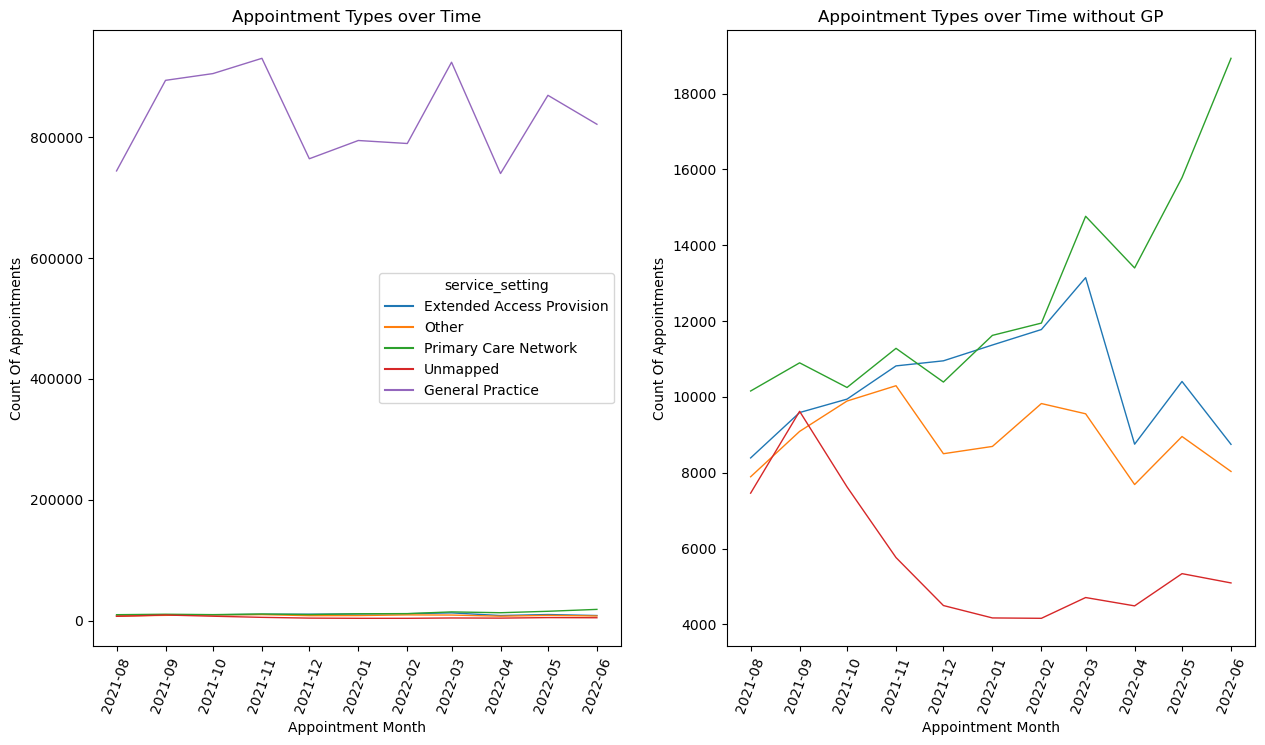

In [36]:
#filter the data to remove GP appointments
filtered_ss_counts = ss_counts[ss_counts['service_setting'] != 'General Practice']

# a plot to visualise appointments by service setting with and without GP appointment
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.lineplot(data = ss_counts, x = 'appointment_month', y='count_of_appointments',
             hue = 'service_setting', lw =1, ax=ax[0])
ax[0].set_title('Appointment Types over Time')  # Add a title
ax[0].set_xlabel('Appointment Month')  # Add x-axis label
ax[0].set_ylabel('Count Of Appointments')  # Add y-axis label

# Plot the second lineplot on the second subplot without GP appointments
sns.lineplot(data = filtered_ss_counts, x = 'appointment_month', y='count_of_appointments',
             hue = 'service_setting', lw =1, ax=ax[1], legend = None)
ax[1].set_title('Appointment Types over Time without GP')  # Add a title
ax[1].set_xlabel('Appointment Month')  # Add x-axis label
ax[1].set_ylabel('Count Of Appointments')  # Add y-axis label

#rotate both x axis labels
for axis in ax:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=70)
plt.savefig('appointment_types_over_time.png')

We can see from the above that GP appointments are by far the most popular service type. At a distance this is followed by primary care network and then extended access provision. 

We can see in the RHS graph that there have been a significant drop in Unmapped occurences and this implies that record keeping has been steadily improving over this time period.

**Question 3. What is the number of appointments and records per month?**

Let's break this down further into the following questions:

**3a.** Which month had the highest number of appointments?

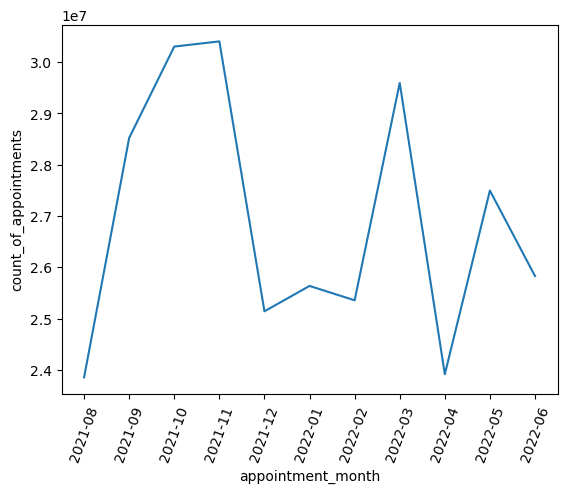

In [37]:
# Number of appointments per month == sum of count_of_appointments by month.
# Use the groupby() and sort_values() functions to create a new dataframe 
nc_month_count = nc.groupby("appointment_month")[['count_of_appointments']].sum() \
    .sort_values(by = ['appointment_month','count_of_appointments'],
                 ascending = [True,False]).reset_index()

#change appointment month type to string for graphing
nc_month_count['appointment_month'] = nc_month_count['appointment_month'].astype(str)

#plot appointments against time for this subset
sns.lineplot(data = nc_month_count , x ='appointment_month', y= 'count_of_appointments')
#rotate x labels 90 degrees for readability, semi-colon to supress printing all labels in output
plt.xticks(rotation=70);

From above we can see November 2021 has the largest number of appointments.

**3b.** What are the total records per month?

In [38]:
# Total number of records per month.
nc.groupby('appointment_month')[['count_of_appointments']].count() \
    .sort_values(by = 'count_of_appointments', ascending = False).head()

#nc.head()

,count_of_appointments
appointment_month,
2022-03,82822
2021-11,77652
2022-05,77425
2021-09,74922
2022-06,74168


**3c.** What is the the number of appointments per month for each icb

In [39]:
nc.groupby(['sub_icb_location_name','appointment_month'])['count_of_appointments'].sum()\
.reset_index().sort_values(by = ['appointment_month','count_of_appointments'],
                           ascending = [True,False]).head()

,sub_icb_location_name,appointment_month,count_of_appointments
836,NHS North West London ICB - W2U3Z,2021-08,981385
737,NHS North East London ICB - A3A8R,2021-08,777887
517,NHS Kent and Medway ICB - 91Q,2021-08,747462
396,NHS Hampshire and Isle Of Wight ICB - D9Y0V,2021-08,661781
902,NHS South East London ICB - 72Q,2021-08,643439


**3d.** What is the the number of appointments per month for each appointment status

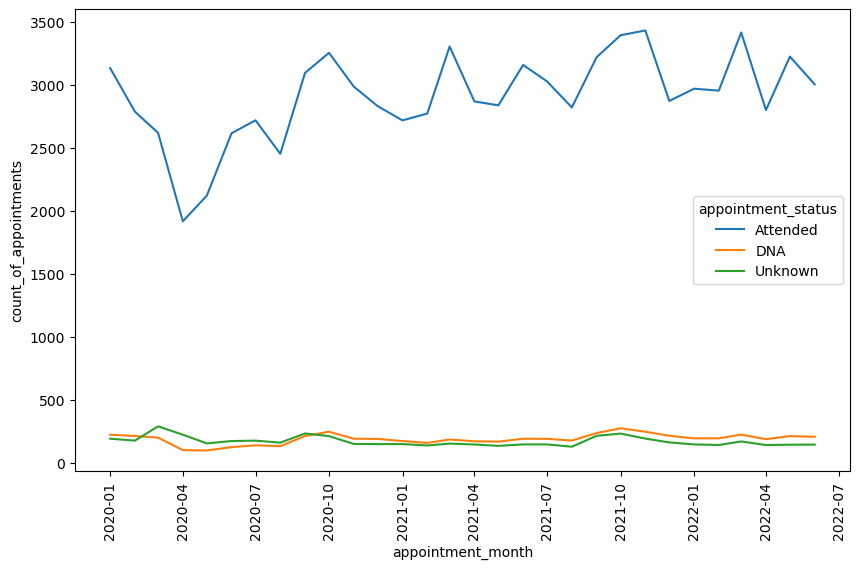

In [40]:
ar['appointment_month'] = ar['appointment_month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=ar, x= 'appointment_month', y='count_of_appointments', hue = 'appointment_status', errorbar=None)

#rotate x labels 90 degrees for readability, semi-colon to supress printing all labels in output
plt.xticks(rotation=90);

**Question 4. What monthly and seasonal trends are evident, based on the number of appointments for service settings, context types, and national categories?**

**Question 4a.** What monthly and seasonal trends are evident, based on the number of appointments for service settings

In [41]:
#define a user defined function to calcualte trends by specified column over the seasons
def plot_seasonal_appointments(data, split_by, legend_position=(1.05, 1)):
    """
    Parameters:
    - data: DataFrame containing appointment data.
    - split_by: Column name to split the data by (e.g., 'service_setting').
    - legend_position: Tuple indicating the legend position in the format (x, y) for bbox_to_anchor.
    """
    # Define seasons and their corresponding months
    seasons = {
        'Autumn 2021': ['2021-09', '2021-10', '2021-11'],
        'Winter 2021/22': ['2021-12', '2022-01', '2022-02'],
        'Spring 2022': ['2022-03', '2022-04', '2022-05']
    }
    
    # Group and aggregate the data
    grouped_data = data.groupby(['appointment_date', 'appointment_month', split_by])['count_of_appointments']\
    .sum().reset_index()
    grouped_data['appointment_month'] = grouped_data['appointment_month'].astype(str)
    
    # Set up figure with multiple subplots
    fig, axes = plt.subplots(1, len(seasons), figsize=(20, 10))  # Fixed figure size
    
    # Plot data for each season
    for i, (ax, (season_name, months)) in enumerate(zip(axes, seasons.items())):
        subset = grouped_data[grouped_data['appointment_month'].isin(months)]
        sns.lineplot(x='appointment_month', y='count_of_appointments', hue=split_by, data=subset, 
                     errorbar=None, ax=ax, palette = 'colorblind')
        ax.set_title(season_name)
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend(loc='upper center', bbox_to_anchor=legend_position, ncol=3)
        else:
            ax.legend_.remove()  # Remove legend from other subplots

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

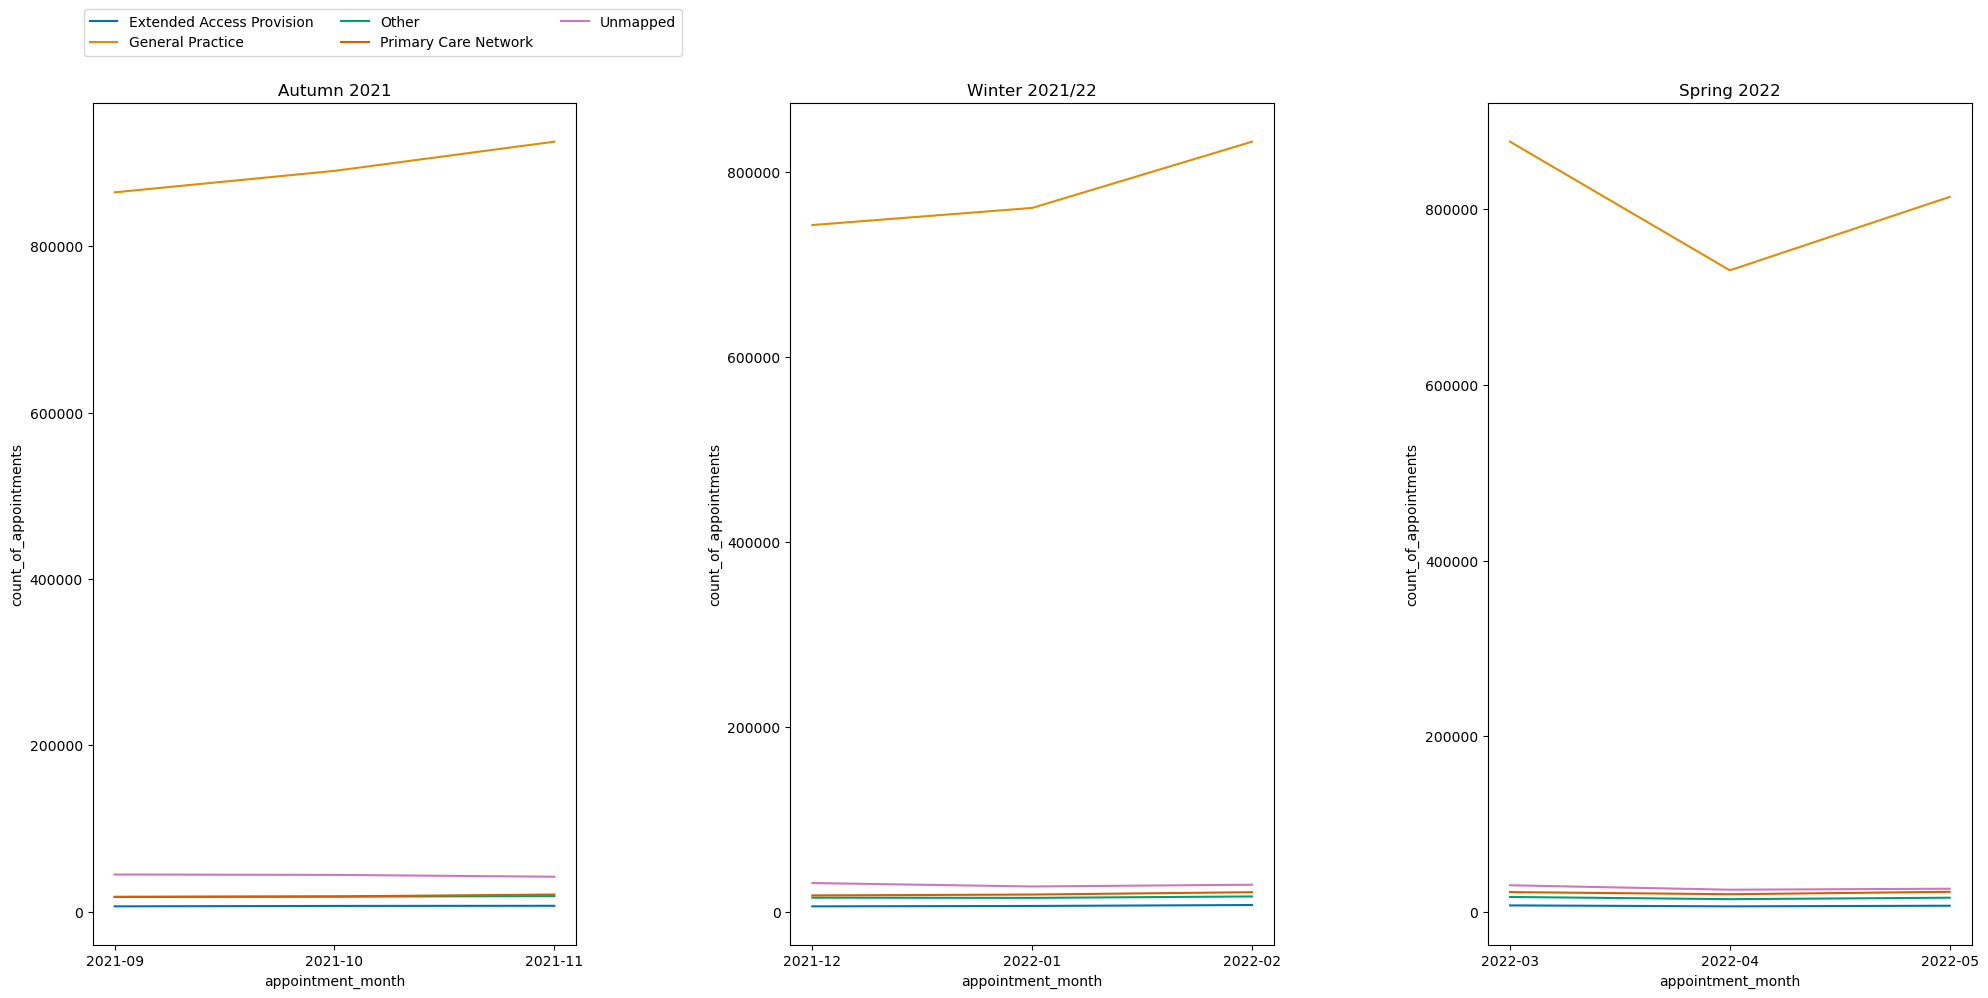

In [42]:
# use the defined function for service settings
plot_seasonal_appointments(nc, split_by='service_setting', legend_position=(.6, 1.12))

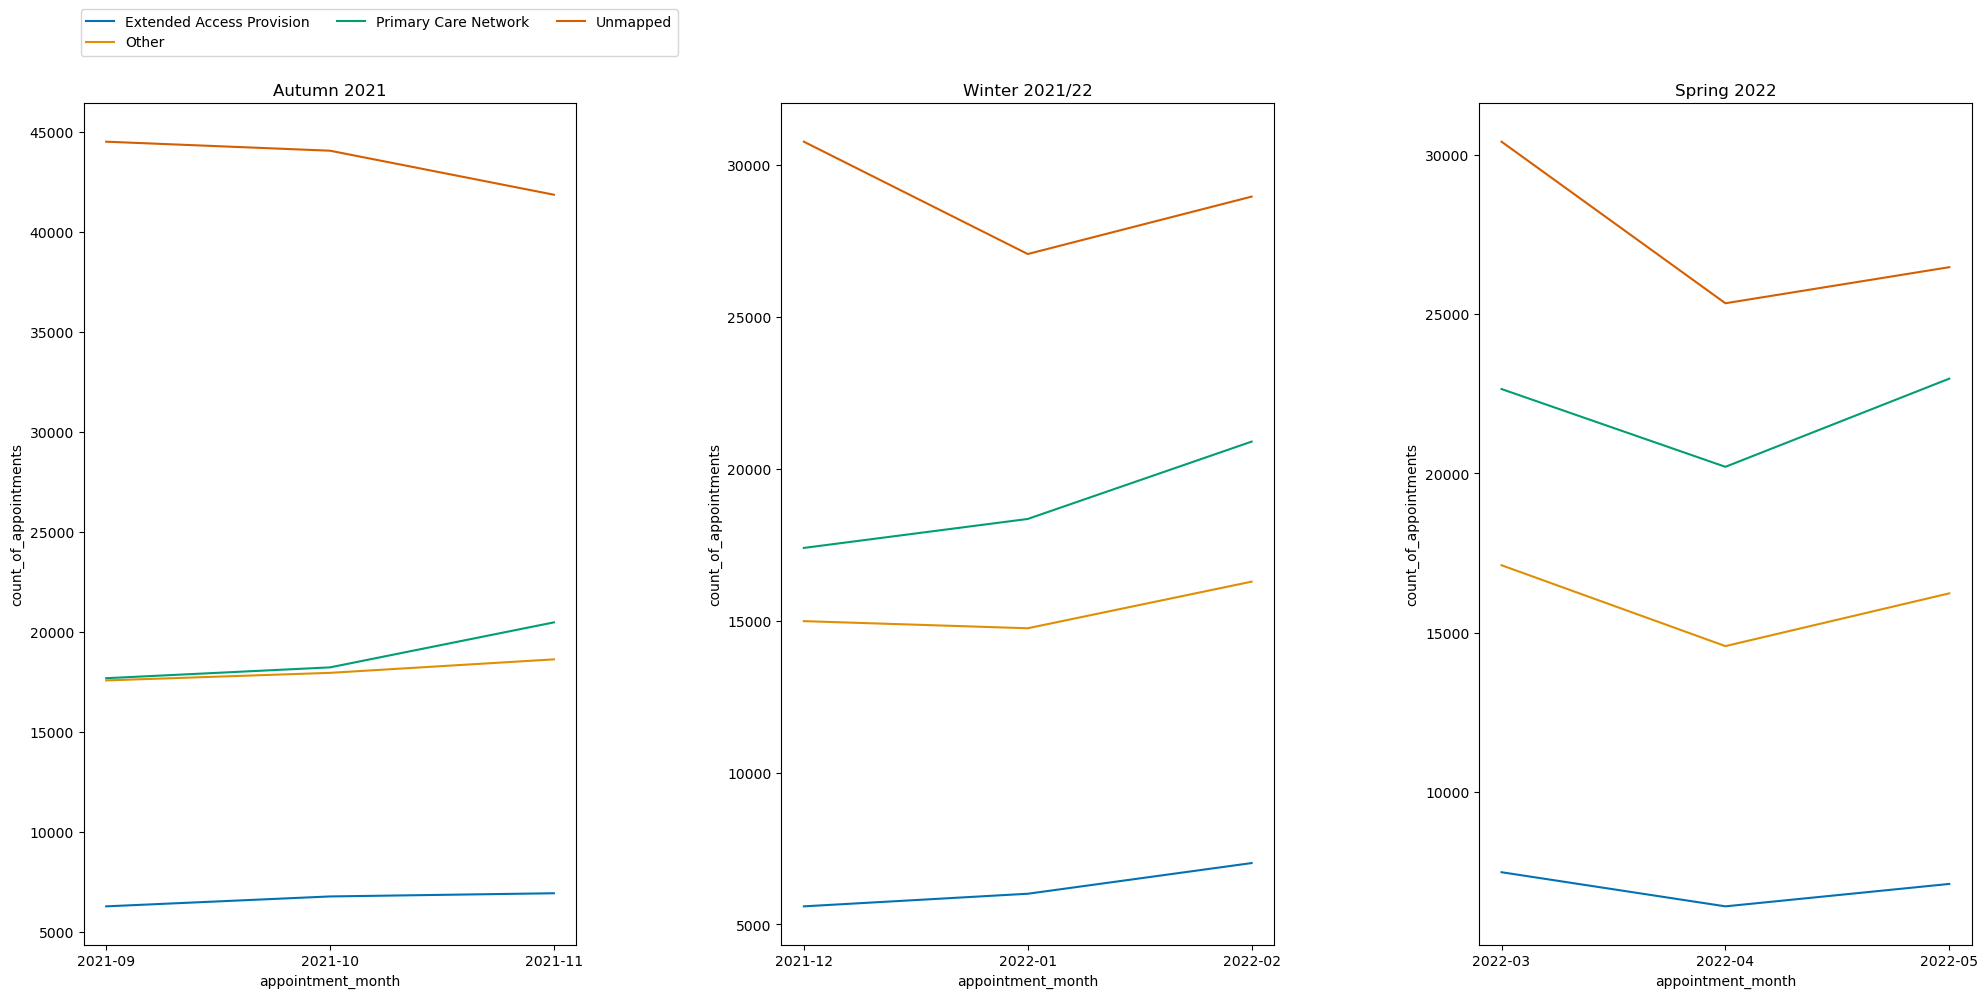

In [43]:
filtered_nc = nc[nc['service_setting'] != 'General Practice']
plot_seasonal_appointments(filtered_nc, split_by='service_setting', legend_position=(.6, 1.12))

We can see from the above that General Practice appointments are far greater in number than any other kind of service setting within this data set. From this data we can't see a general rise or fall in appointments across the time period, they seem to remain quote consistent from Sep 2021 up until May 2022 with a small dip across December & April which could be due to GPs being closed over a number of days for the christmas and easter period.

**Question 4b.** What monthly and seasonal trends are evident, based on the number of appointments for context types

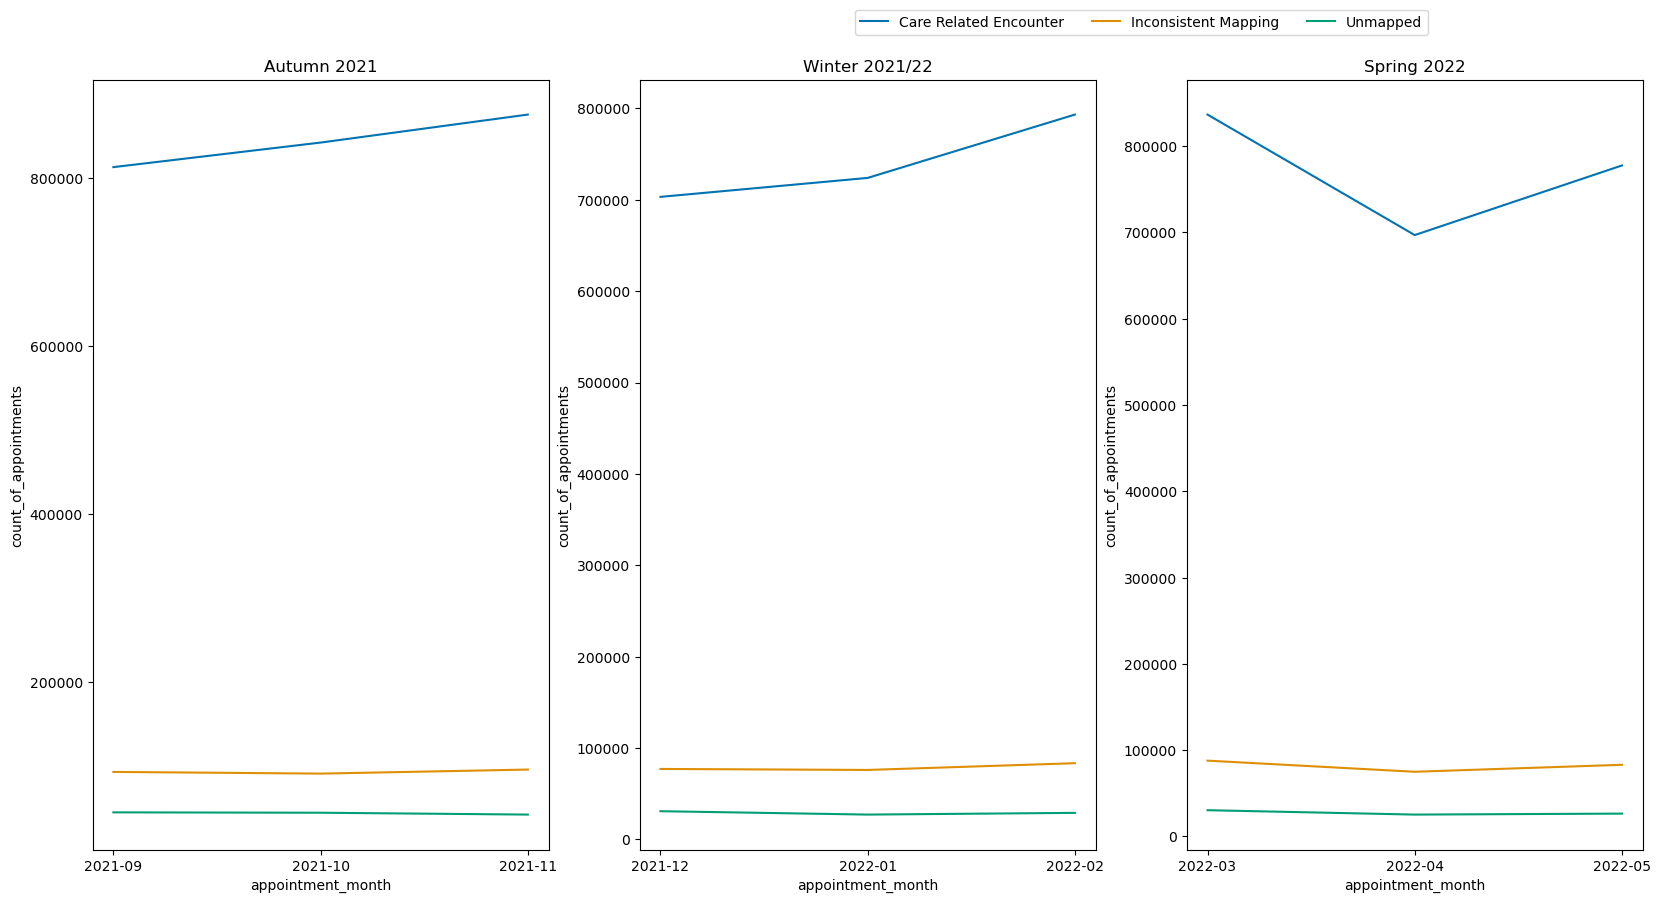

In [44]:
# use the defined function for context type
plot_seasonal_appointments(nc, split_by='context_type', legend_position=(2.3, 1.1))

The context type of 'Care Related Encounter' is the only substantial information as the other two categories are inconsistent or unmapped. These also have a similar dip as before in December and April likely due to the holidays.

**Question 4c.** What monthly and seasonal trends are evident, based on the number of appointments for national categories

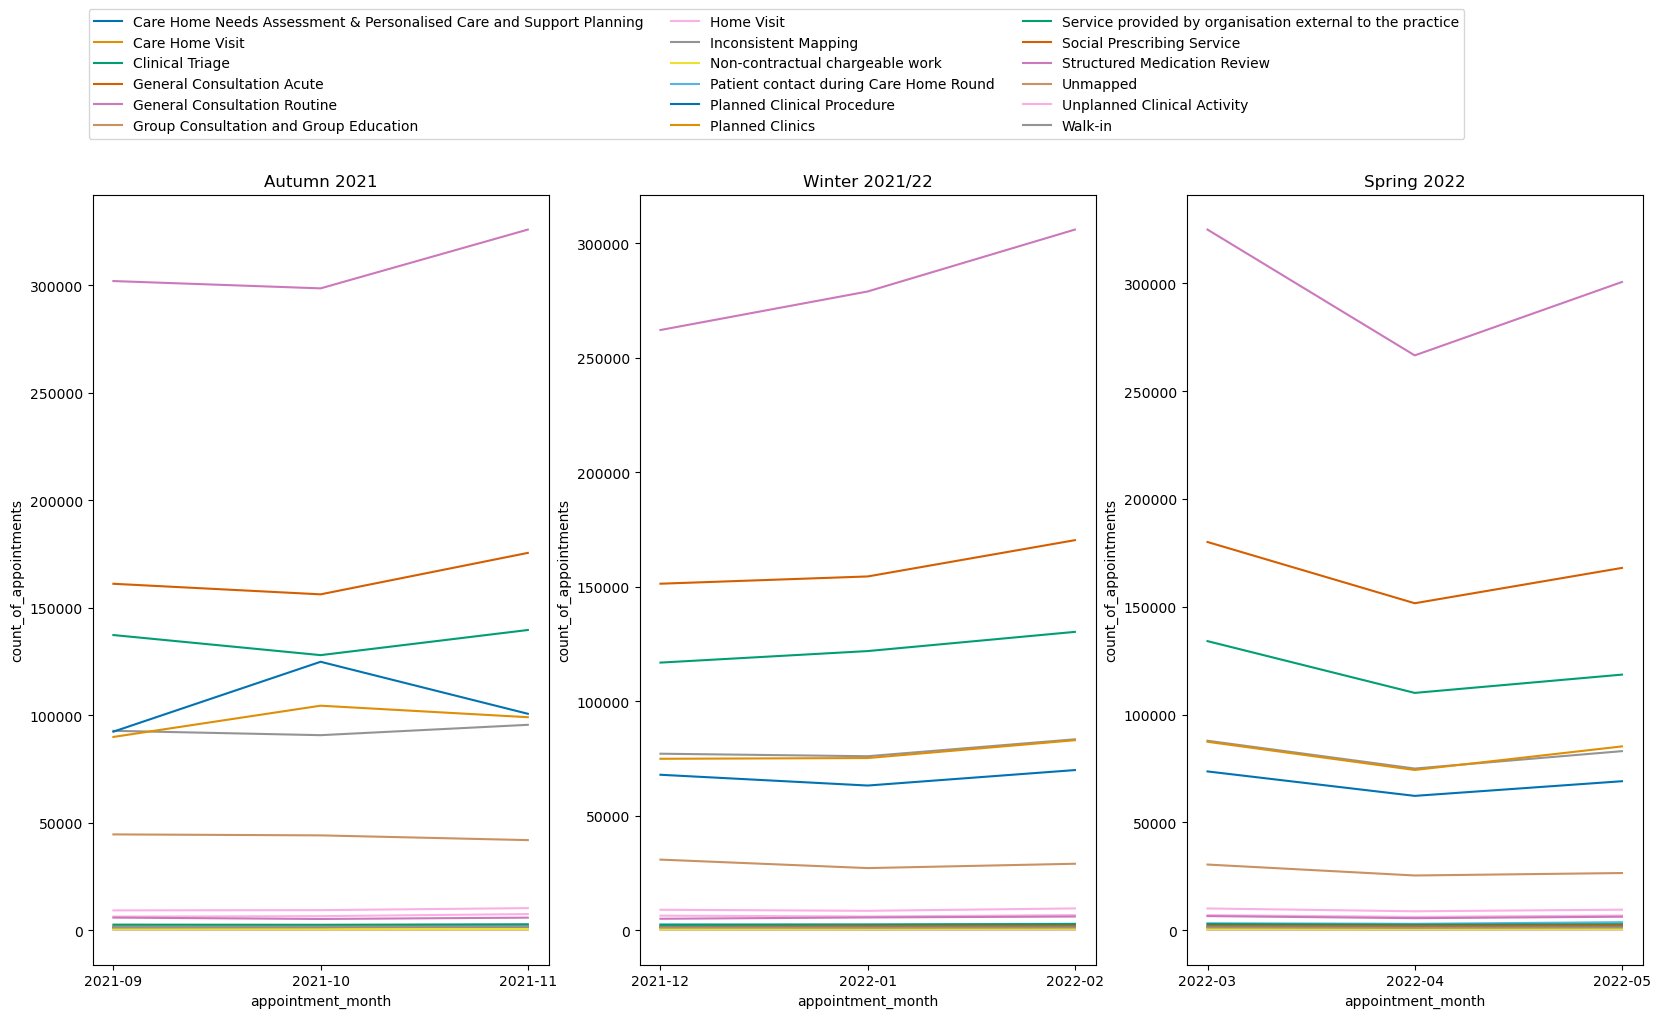

In [45]:
# use the defined function for context type
plot_seasonal_appointments(nc, split_by='national_category', legend_position=(1.5, 1.25))

You can see above that General Consultation Routine is the most common appointment type followed by General Consultation Acute then Clinical Triage

**Question 5: What are the top trending hashtags (#) on the supplied Twitter data set and how can this be used in the decision-making process?**

In [46]:
# view the frequency that tweets are retweeted and favourited
tweets[['tweet_retweet_count','tweet_favorite_count'] ].value_counts().reset_index().\
sort_values(by = ['tweet_retweet_count','tweet_favorite_count'],ascending=[False, False]).head()

,tweet_retweet_count,tweet_favorite_count,count
78,303,0,1
12,208,0,12
32,207,0,3
48,169,0,1
27,150,0,4


We can see from this initial view that retweeting is far more popular within this dataset than favouriting items and so may focus further analysis on highly retweeted posts as opposed to favourited.

In [47]:
#Below we use a loop to pull out any hashtags used in the dataset into a list

#create an empty list to fill
tags = []

# Loop through the messages, and add words containing the # symbol to the above list
for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase and add to the tags object
            tags.append(z.lower())
            
#turn list into DataFrame
tags_df = pd.DataFrame(tags, columns=['hashtags']) 

tags_df.head()

,hashtags
0,#healthcare
1,#premisehealth
2,#hiring
3,#healthcare
4,🚨#new:🚨


In [48]:
#create a new dataframe with hashtags and their counts
tweet_data = tags_df['hashtags'].value_counts().reset_index()

tweet_data.head()

,hashtags,count
0,#healthcare,716
1,#health,80
2,#medicine,41
3,#ai,40
4,#job,38


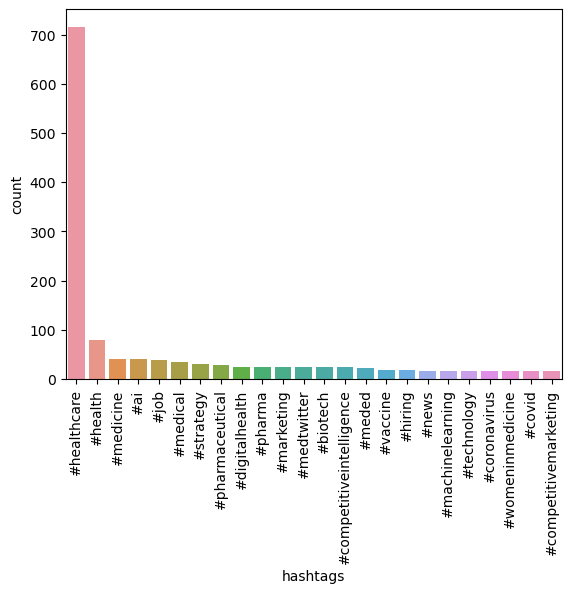

In [49]:
#filter for counts over 15 and view in a bar plot
filtered_tweet_data = tweet_data[(tweet_data['count'] > 15)]

sns.barplot(data=filtered_tweet_data, x= 'hashtags', y='count')
#rotate x labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

Let's removed the outlier of #healthcare so we can have a better look at the remaining data on the plot.

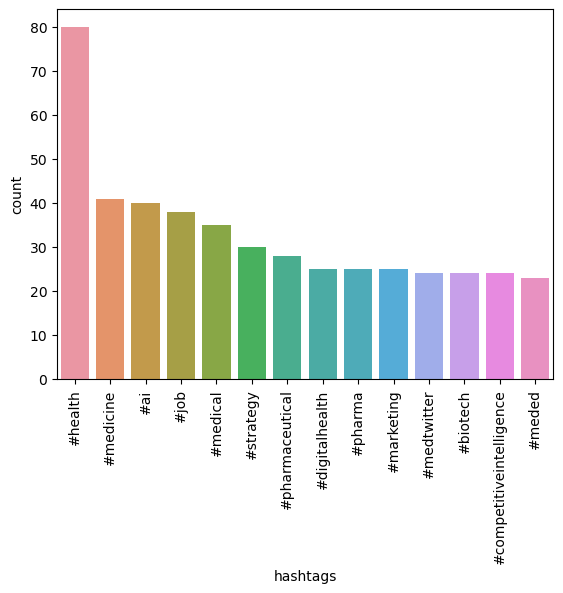

In [50]:
#filter to remove the outlier of #healthcare and see data in more detail
filtered_tweet_data = tweet_data[(tweet_data['count'] > 20) & (tweet_data['count']< 100)]

sns.barplot(data=filtered_tweet_data, x= 'hashtags', y='count')
#rotate x labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

**Question 6. Was there adequate staff and capacity in the networks?**

We can begin looking at this question by reviewing the staff data we have for the NHS

In [51]:
#melt the staff_data so we are able to create on a lineplot
melted_staff_data = pd.melt(staff_data, id_vars=[col for col in staff_data.columns if col not in\
                                                 ['London', 'South West','South East','Midlands','East of England',\
                                                  'North West','North East and Yorkshire']],
                      value_vars=['London', 'South West','South East','Midlands','East of England','North West',\
                                  'North East and Yorkshire'],
                      var_name='Region', value_name='Total Staff')
#preview data
melted_staff_data.head()

,Date,Region,Total Staff
0,2020-01-01,London,193959
1,2020-02-01,London,194470
2,2020-03-01,London,195510
3,2020-04-01,London,197343
4,2020-05-01,London,198913


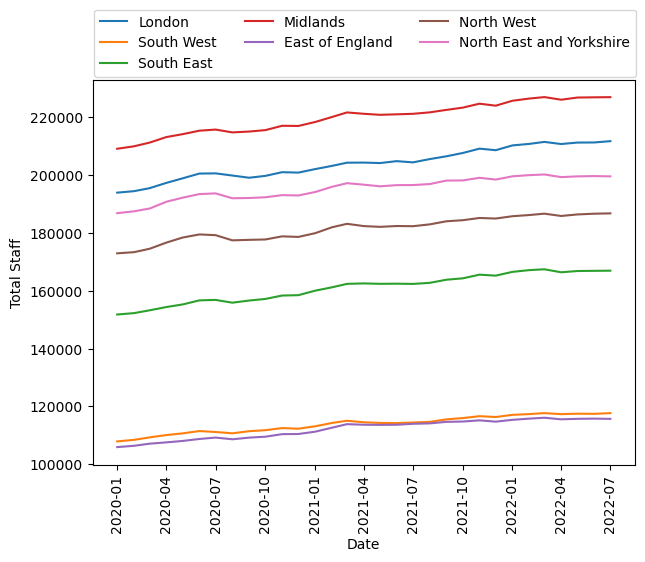

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=melted_staff_data, x='Date', y='Total Staff', hue = 'Region')

#rotate x labels by 90 degrees
plt.xticks(rotation=90);
#adjust legend posistion for best view
ax.legend(loc='upper left', bbox_to_anchor=(-.01, 1.2), ncol=3)  

# Show the plot
plt.show()

In [53]:
#define a user defined function to calculate percentage increases in certain columns of a dataframe
def calculate_percentage_increase(df, cols, date_column):
    # Get the earliest and latest dates
    min_date = df[date_column].min()
    max_date = df[date_column].max()
    # Initialize a list to store percentage increases
    percentage_increases = []
    # Calculate the percentage increase for each column
    for column in cols:
        # Find the value for the earliest date
        min_val = df.loc[df[date_column] == min_date, column].values[0]
        # Find the value for the latest date
        max_val = df.loc[df[date_column] == max_date, column].values[0]
        # Calculate the percentage increase
        perc_inc = (max_val - min_val) / min_val
        # Format as a percentage string with 2 decimal places
        formatted_percentage = f"{perc_inc:.2%}"
        # Append to the list
        percentage_increases.append(formatted_percentage)

    # Convert the list to a pandas Series with the column names as the index
    result_series = pd.Series(percentage_increases, index=cols)

    return result_series

#calculate percentage increase for staffing over the given data NHS set
cols = ['London', 'South West', 'South East', 'Midlands','East of England', 'North West', 'North East and Yorkshire']
staff_inc_series = calculate_percentage_increase(staff_data, cols, 'Date')
print(staff_inc_series)

London                      9.19%
South West                  9.06%
South East                  9.99%
Midlands                    8.54%
East of England             9.22%
North West                  7.99%
North East and Yorkshire    6.81%
dtype: object


We can see from the graph that the staffing levels have increased since 2020 but we need to compare this to demand if we are to actually glean insights. Also note that the starting point on the y axis is not 0 and so although this appears to be an steady rise, on a more zoomed out axis this would appear almost flat.

To gain better insight I have also calculated the percentage increases of each region of staffing and from this we can see the average increase has been 8.59%. Let's now compare this to appointment counts.

In [54]:
#create a new set grouping by month with a sum of appointments for each month
ar_group = ar.groupby('appointment_month',as_index=False)['count_of_appointments'].sum().\
           sort_values(by='appointment_month', ascending=True)

#merge the above set with our staffing data for comparison
staff_ar_merge = ar_group.merge(melted_staff_data, left_on='appointment_month', right_on='Date')

#group the data by month so we can see the Total staff and total appointments for each month
staff_ar = staff_ar_merge.groupby(['appointment_month','count_of_appointments'])['Total Staff'].sum().reset_index().\
sort_values(by='appointment_month', ascending=True)

#view the data
staff_ar.head()

,appointment_month,count_of_appointments,Total Staff
0,2020-01-01,27199296,1128525
1,2020-02-01,24104621,1132392
2,2020-03-01,24053468,1139420
3,2020-04-01,16007881,1150054
4,2020-05-01,16417212,1157739


In [55]:
#calculate percentage increase for appointments across the ar data set using our predefined user function
ar_inc_series = calculate_percentage_increase(ar, ['count_of_appointments'],'appointment_month')
ar_inc_series

count_of_appointments    -7.31%
dtype: object

Surprisingly, despite the staffing increase we appear to have a decrease across our appointment count, this could be due to many factors but it is likely that as our data set begins in 2020 there was an increase in demand for appointments due to COVID and this may be skewing our results slighlty. Toclarify let's take the data set from April onwards from 2020 and the look at this further by reviewing staff and appointment data together against each other on one graph.

In [56]:
#calculate the percentage increase from April 2020 to June 2022
set_date='2020-04'
#create a new subset of date for dates after April 2020
staff_data_2020 = staff_data[staff_data['Date']>=set_date]

#use predefined function and cols with new data set to gain new info
staff_inc_series = calculate_percentage_increase(staff_data_2020, cols, 'Date')
#print
print(f'{bold}Staff Increases:{reset}')
print(staff_inc_series)


#create a new subset of date for dates after April 2020
ar_2020 = ar[ar['appointment_month']>=set_date]

#use predefined function with new data set to gain new info
ar_inc_series_apr_20 = calculate_percentage_increase(ar_2020, ['count_of_appointments'],'appointment_month')
print(f'{bold}Appointment Increases:{reset}')
print(ar_inc_series_apr_20)

Staff Increases:
London                      7.31%
South West                  6.89%
South East                  8.15%
Midlands                    6.48%
East of England             7.56%
North West                  5.72%
North East and Yorkshire    4.60%
dtype: object
Appointment Increases:
count_of_appointments    320.48%
dtype: object


In [57]:
#melt the above data frame so we are able to use it in a lineplot
staff_ar_melt = pd.melt(staff_ar, id_vars=[col for col in staff_ar.columns if col not in\
                                                 ['count_of_appointments','Total Staff']],
                      value_vars=['count_of_appointments','Total Staff'],
                      var_name='Count type', value_name='Total'
                       )

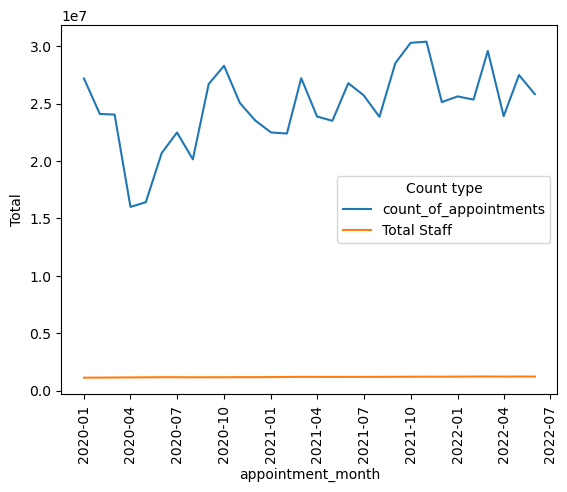

In [58]:
sns.lineplot(data=staff_ar_melt, x = 'appointment_month', y='Total', hue = 'Count type')
plt.xticks(rotation=90);

We can see above that there has been a large variance across appointments but as we look at this level of range we lose the nuance of increase across staffing levels. There is also a very slight upward trend in the appointment data but this should be reviewed further with a larger data set for confirmation.

In [59]:
#calculating the staff to appointment ratio
staff_ar['Staff:Appointment ratio'] = staff_ar['Total Staff']/(staff_ar['count_of_appointments']/30)

staff_ar.describe()

,appointment_month,count_of_appointments,Total Staff,Staff:Appointment ratio
count,30,3.000000e+01,3.000000e+01,30.000000
mean,2021-03-17 04:00:00,2.476015e+07,1.186503e+06,1.467390
min,2020-01-01 00:00:00,1.600788e+07,1.128525e+06,1.196568
25%,2020-08-08 18:00:00,2.351528e+07,1.164412e+06,1.323781
50%,2021-03-16 12:00:00,2.510119e+07,1.194446e+06,1.425411
75%,2021-10-24 06:00:00,2.709552e+07,1.211530e+06,1.530029
max,2022-06-01 00:00:00,3.040507e+07,1.226678e+06,2.155290
std,NaN,3.472766e+06,2.942316e+04,0.227178


**Question 7. What was the actual utilisation of resources?**

The NHS has provided a figure of an average of 1,200,000 appointments per day being used for planning purposes, which we can use as a guideline for maximum capacity. With this information let's calculate if this capacity has been reached across the NHS network and the actual utilisation of resources.

In [60]:
#creating a new dataframe to review regional appointment data
ar_agg = ar.groupby(['appointment_month', 'hcp_type', 'appointment_status', 'appointment_mode',\
                     'time_between_book_and_appointment'])\
         ['count_of_appointments'].sum().reset_index()
ar_agg.head(1)

,appointment_month,hcp_type,appointment_status,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,2020-01-01,GP,Attended,Face-to-Face,1 Day,653846


In [61]:
#determine the average utilisation of services
#use previously defined ar_group (number of appointments by month) and add a utilisation column
ar_group['utilisation']= ar_group['count_of_appointments']/30 /1200000

#convert to percentage (times 100)
ar_group['utilisation (%)'] = (ar_group['utilisation']*100)

ar_group.describe()

,appointment_month,count_of_appointments,utilisation,utilisation (%)
count,30,3.000000e+01,30.000000,30.000000
mean,2021-03-17 04:00:00,2.476015e+07,0.687782,68.778197
min,2020-01-01 00:00:00,1.600788e+07,0.444663,44.466336
25%,2020-08-08 18:00:00,2.351528e+07,0.653202,65.320223
50%,2021-03-16 12:00:00,2.510119e+07,0.697255,69.725525
75%,2021-10-24 06:00:00,2.709552e+07,0.752653,75.265326
max,2022-06-01 00:00:00,3.040507e+07,0.844585,84.458528
std,NaN,3.472766e+06,0.096466,9.646571


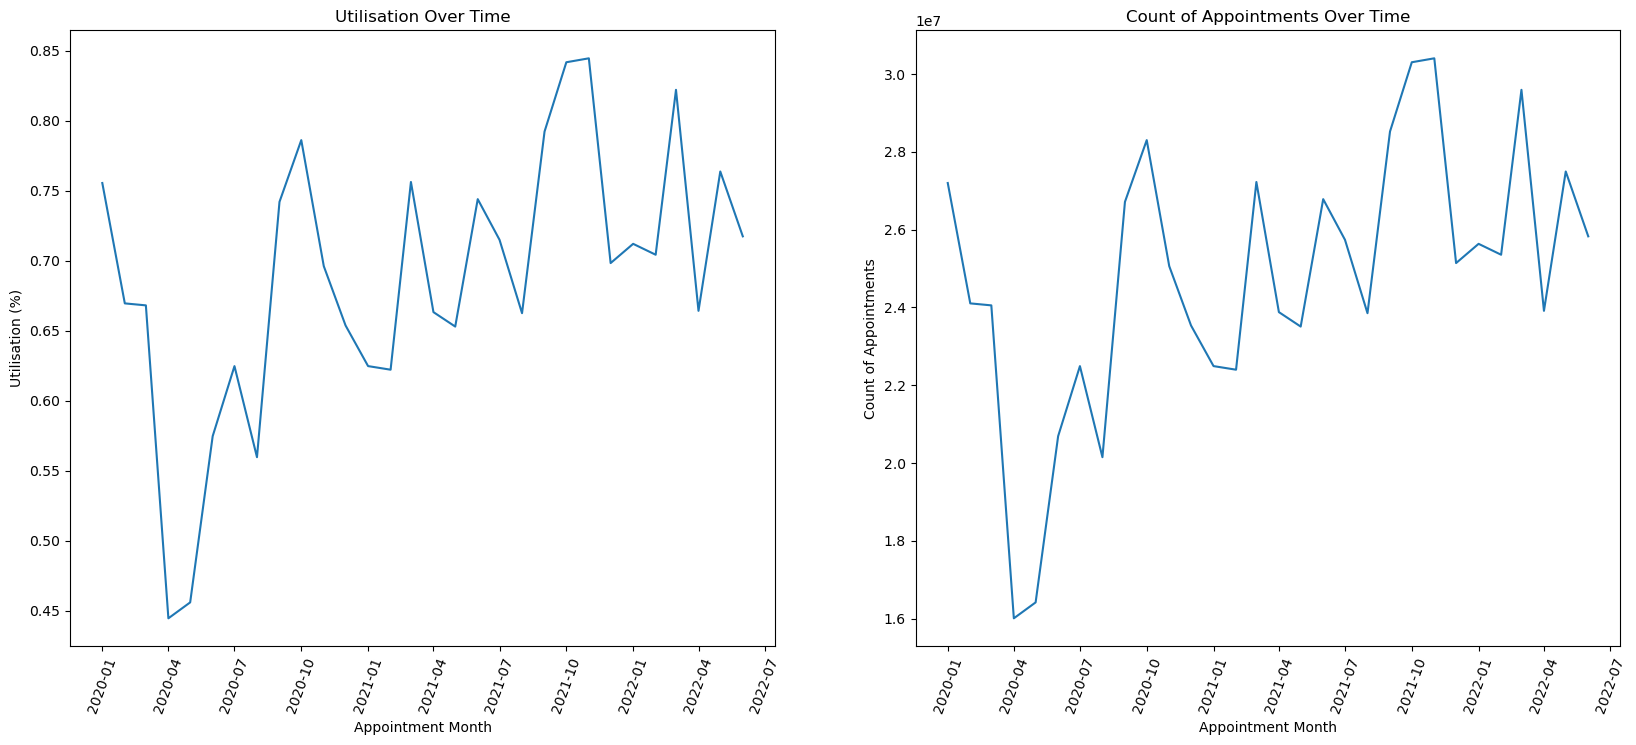

<Figure size 640x480 with 0 Axes>

In [62]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8)) 

# Plot the first lineplot on the first subplot of utilisation over time
sns.lineplot(data=ar_group, x='appointment_month', y='utilisation', ax=ax[0])
ax[0].set_title('Utilisation Over Time')  # Add a title
ax[0].set_xlabel('Appointment Month')  # Add x-axis label
ax[0].set_ylabel('Utilisation (%)')  # Add y-axis label

# Plot the second lineplot on the second subplot of appointment count over time
sns.lineplot(data=ar_group, x='appointment_month', y='count_of_appointments', ax=ax[1])
ax[1].set_title('Count of Appointments Over Time')  # Add a title
ax[1].set_xlabel('Appointment Month')  # Add x-axis label
ax[1].set_ylabel('Count of Appointments')  # Add y-axis label

# Rotate x-axis labels for both subplots for better readability
for axis in ax:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=70)

# Show the plot
plt.show()
plt.savefig('Utilisation_over_time.png')

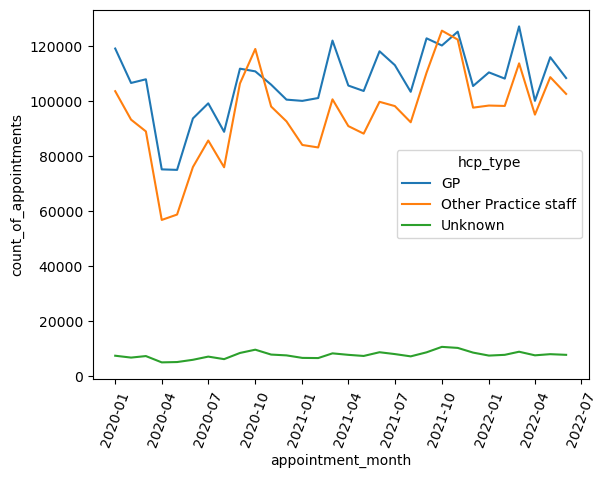

In [63]:
sns.lineplot(data=ar_agg, x='appointment_month', y='count_of_appointments', hue = 'hcp_type',errorbar=None)

plt.xticks(rotation=70);

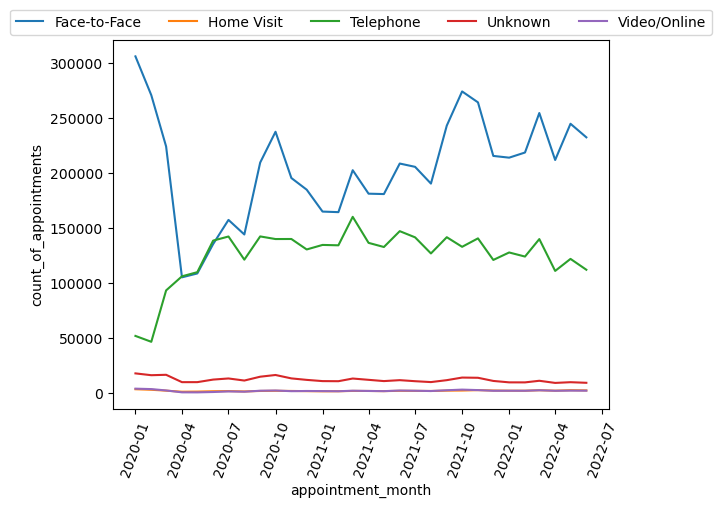

In [64]:
sns.lineplot(data=ar_agg, x='appointment_month', y='count_of_appointments', hue = 'appointment_mode',errorbar=None)
ax = plt.gca()
# Adjust legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)  
plt.xticks(rotation=70);

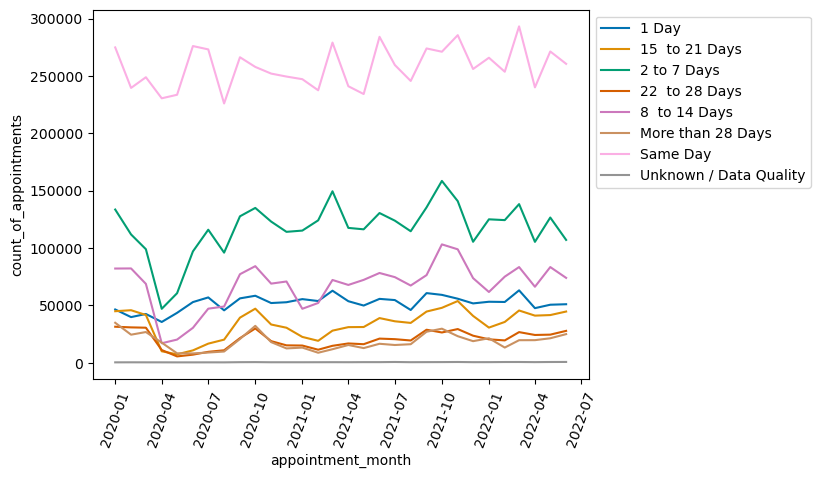

In [65]:
sns.lineplot(data=ar_agg, x='appointment_month', y='count_of_appointments', 
             hue = 'time_between_book_and_appointment',errorbar=None, palette = 'colorblind')
ax = plt.gca()
# Adjust legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)  
plt.xticks(rotation=70);

**Question 8. What insights can be gained by looking at missed appointments?**

To do this we can look at the count of each status and our graph from question **3d**:

In [66]:
value_counts = ar.groupby('appointment_status')['count_of_appointments'].sum()

#normalise the counts to get percentages
percentage_counts = (value_counts / value_counts.sum()) * 100

#format the percentages to two decimal places with a percentage sign
percentage_counts = percentage_counts.round(2).astype(str) + '%'

# View the result
percentage_counts

appointment_status
Attended    91.24%
DNA          4.16%
Unknown       4.6%
Name: count_of_appointments, dtype: object

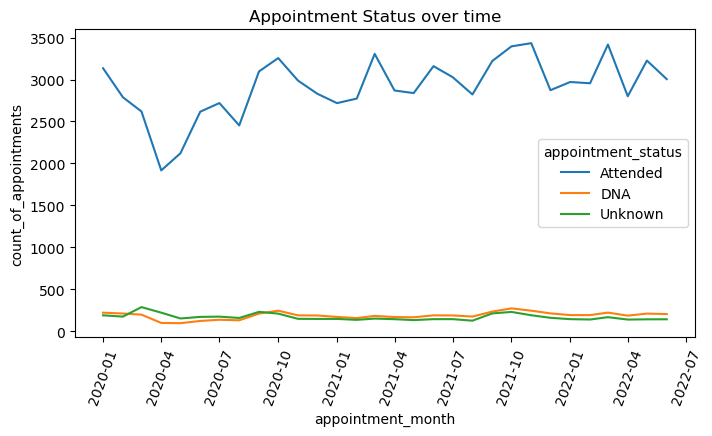

In [67]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=ar, x= 'appointment_month', y='count_of_appointments', hue = 'appointment_status', errorbar=None)

fig.suptitle('Appointment Status over time', fontsize=12, y=0.93)
#rotate x labels 90 degrees for readability, semi-colon to supress printing all labels in output
plt.xticks(rotation=70);

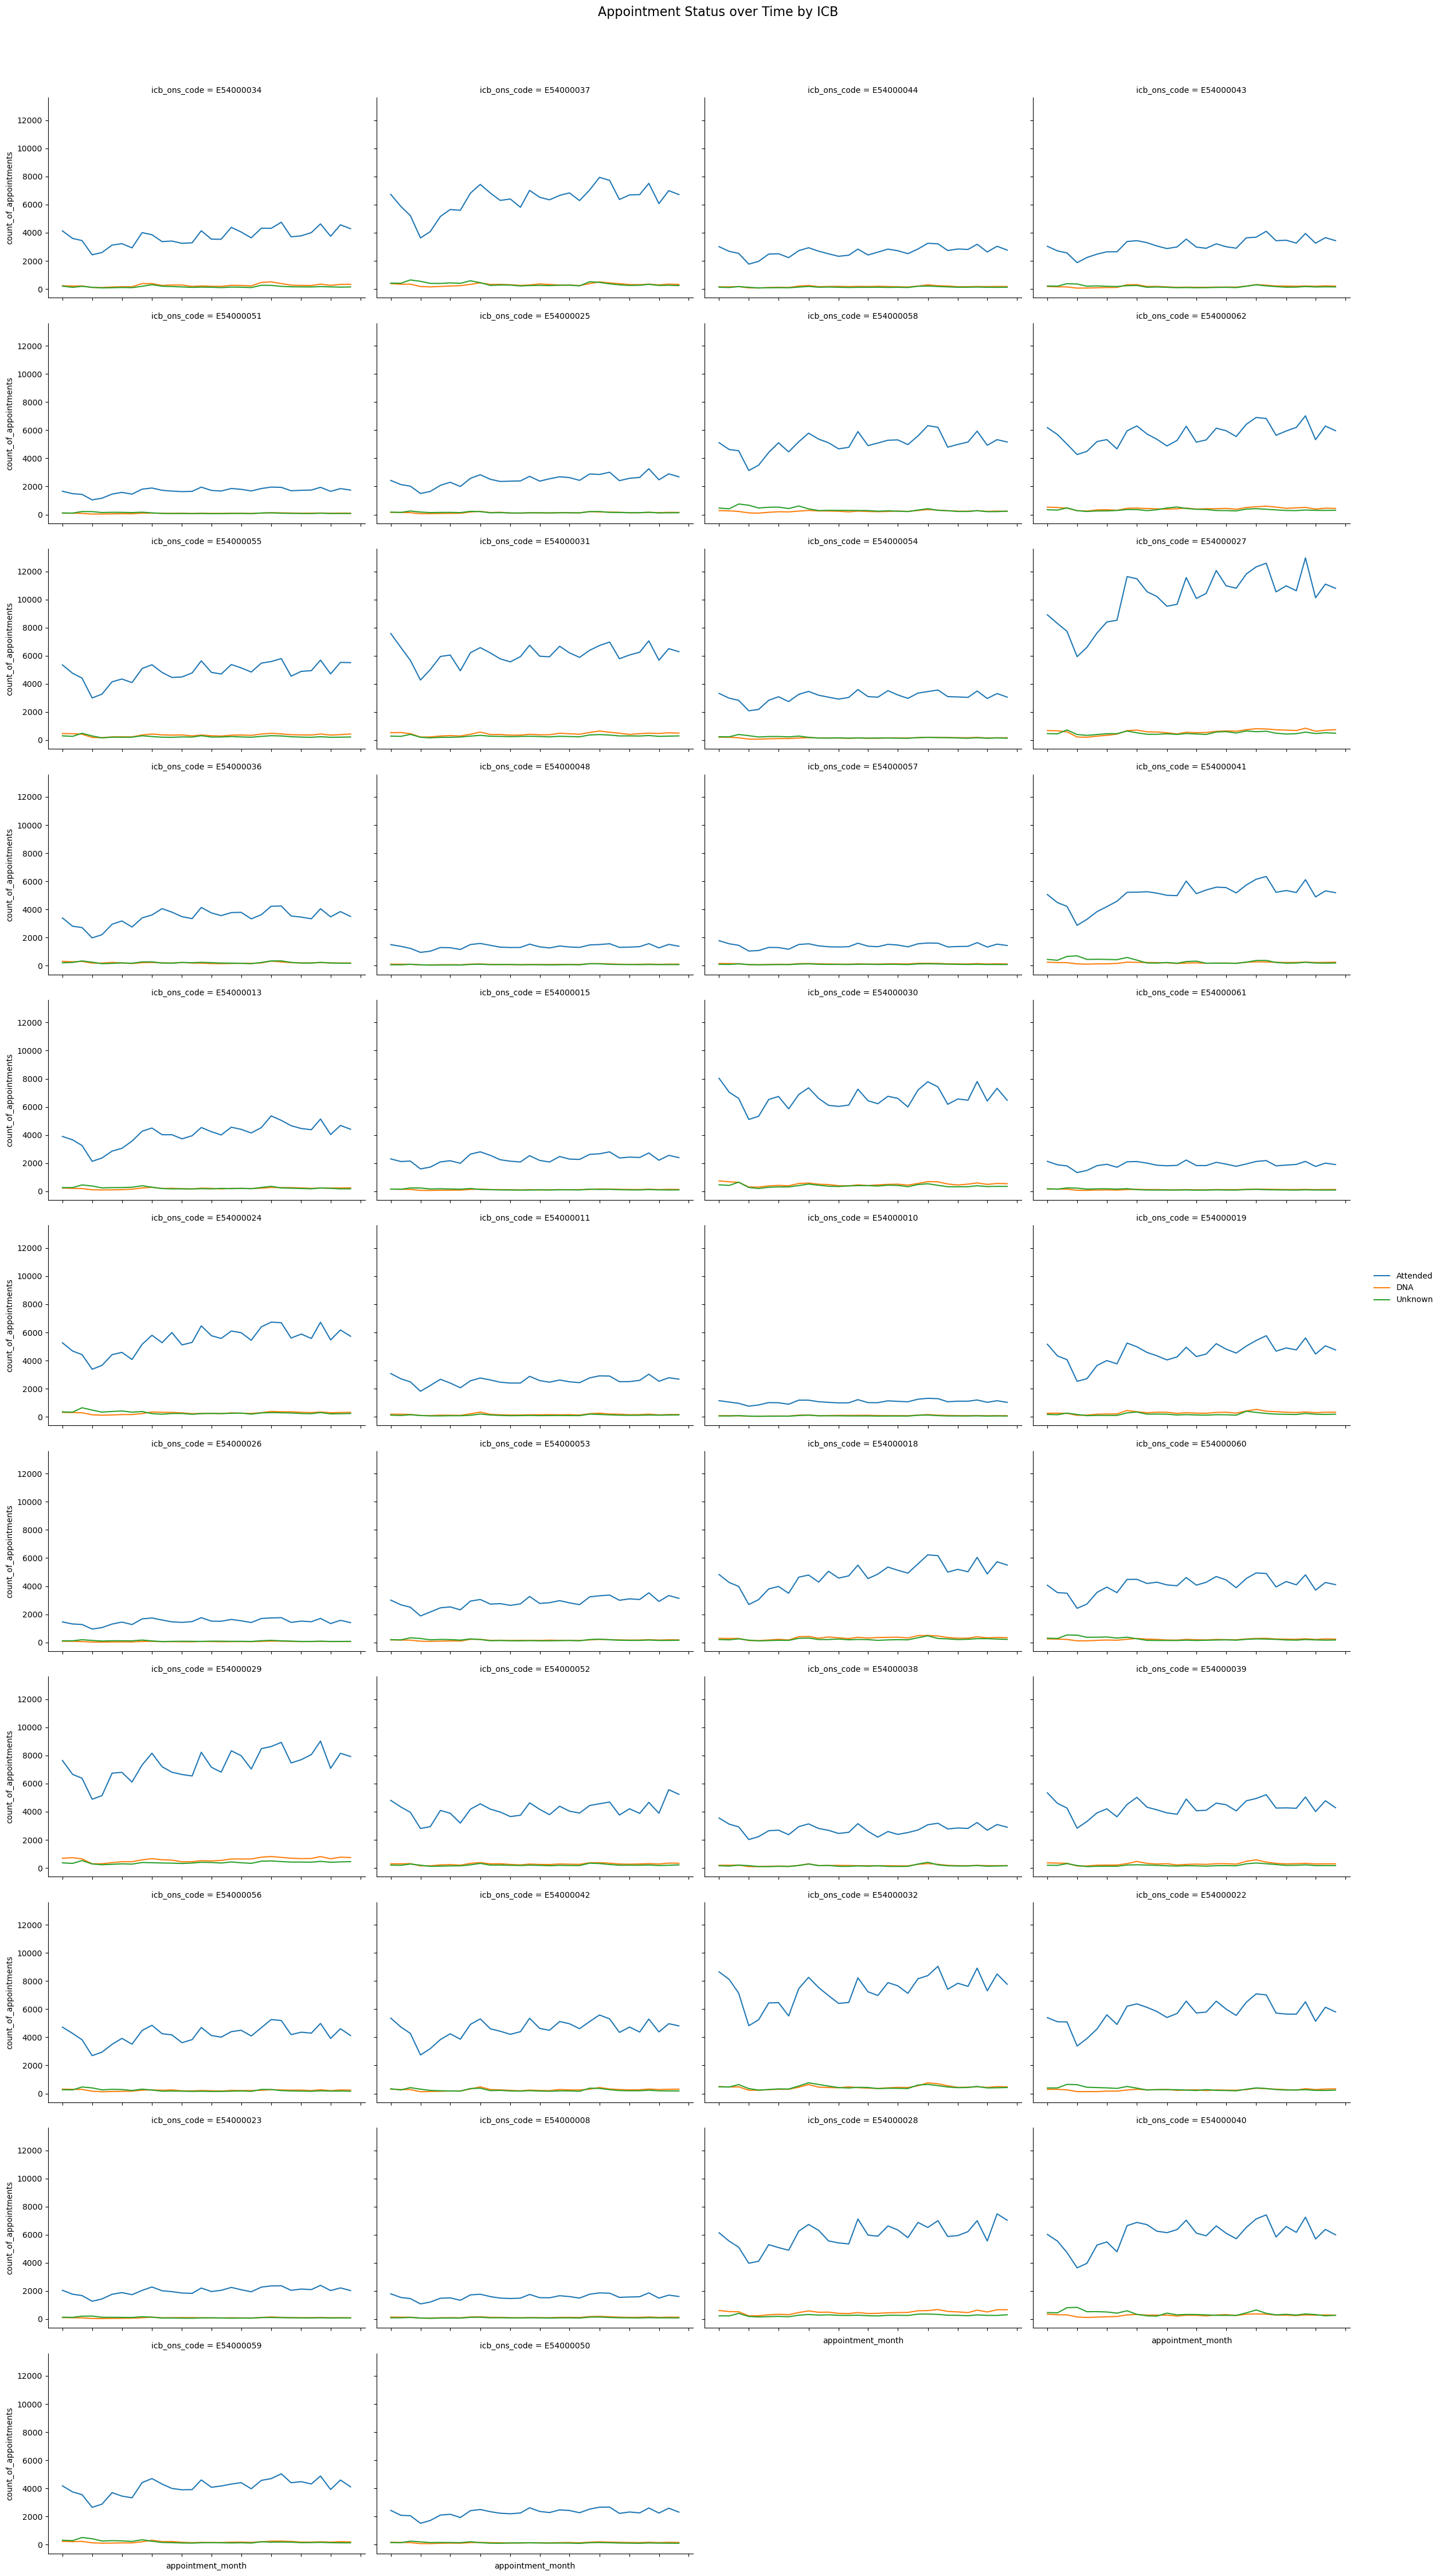

In [68]:
# Create a FacetGrid, faceting on the 'icb_ons_code' column
g = sns.FacetGrid(ar, col='icb_ons_code', col_wrap=4, height=4, aspect=1.5)

# Map the lineplot onto the FacetGrid
g.map(sns.lineplot, 'appointment_month', 'count_of_appointments', 'appointment_status', errorbar=None)

# Rotate the x-axis labels for readability
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

# Adjust the overall title and layout
g.fig.suptitle('Appointment Status over Time by ICB', fontsize=16, y=1.02)
g.add_legend()

# Adjust the layout
g.tight_layout()

We can see from the above that the volume of appointments that have been missed are immaterial compared to the Attended appointments in the data set. It is unlikely that 4% of appointments would have a large effect on resourcing unless locations were at the maximum capacity which we have found from the utilisation data is not the case at the moment.

We can also see from our FacetGrid that each ICB location follows the same general pattern and so there is not an outlier location that is skewing the data

## Conclusion
### Main insights
 - Appointments and population have a strong positive correlation so there is a general standard for health across all locations. The majority of locations serve a smaller population with a lower number of appointments and there are only a few on the higher range with large populations and large appointment numbers.
 - NHS North West London ICB - W2U3Z is the largest sub ICB location in all aspects: populaion, appointment count and staffing.
 - GP appointments are by far the most popular service settings, followed at a distance by primary care network and then extended access provision.
   - There has been a large reduction in umnapped service settings between 2021 and 2022 implying that record keeping in this period has improved greatly.
   - There has been a steep incline in Primary Care Network and Extended Access Provision appointment recordings as Unmapped has declined. This could be due to the reclassification of an appointment type or more effective staff training on record keeping. Further investigation in this area could prove useful to roll out whatever method has been so successful here to other areas of record keeping. 
 - In all areas of service there is a slight dip across December and April periods likely due to Bank Holidays.
 - Our Twitter analysis currently does not reveal any popular hashtags indicating negative sentiment towards NHS staffing levels.
 - There has been an 8.6% increase in staffing levels from 2020 to 2022 and a decrease of 7% in appointments across the same period. This is likely due to the effects of the pandemic having effected the 2020 data heavily.
 - We can garner the staff to patient ratio by comparing staff to appointments per day. This gives us and average of 1.47 per day.
   - A closer look at this value would be beneficial as the staffing data includes all NHS workers and looking at this broken down into support staff, front of house etc. would give us a deeper insight into this value.
 - The utilisation of resources is averaging below 100% for the total appointments across the data set.
   - Looking at this at a deeper level per location would be beneficial for better insight.
 - Missed appointments are at low enough volumes so they should not effect the overall efficiency of the NHS. 
   - For a deeper analysis we have also checked across all ICB locations to confirm this is the case across the board and there is not an outlier location that is skewing results
### Limitations 
- This analysis has not assessed utilisation at a location level and so although we have concluded utilisation is running at under 100% and therefore services are not at their maximum capacity we do not know this for sure as there could be some locations running at over maximum and some under.
- Data sets are not all from within the same time frame and so some estimates and presumptions have been made
- Staffing data was not available at an ICB level, this data could be beneficial for deeper insight.